# Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
projects = pd.read_csv('projects.csv')
outcomes = pd.read_csv('outcomes.csv')
essays = pd.read_csv('essays.csv')
resources = pd.read_csv('resources.csv')

# Data Prep

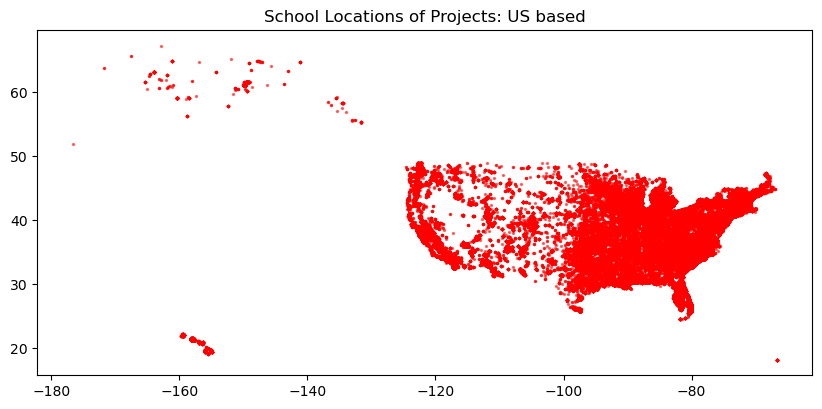

In [3]:
essays['full_essay'] = (
    essays['title'].fillna('') + ' ' +
    essays['short_description'].fillna('') + ' ' +
    essays['need_statement'].fillna('') + ' ' +
    essays['essay'].fillna('')
)
essays['essay_length'] = essays['full_essay'].apply(lambda x: len(str(x).split()))
essays_features = essays[['projectid', 'essay_length']]
resources['total_cost'] = resources['item_unit_price'] * resources['item_quantity']
resource_summary = resources.groupby('projectid').agg({
    'item_quantity': 'sum',
    'item_unit_price': ['mean', 'max'],
    'total_cost': ['sum', 'mean']
}).reset_index()

# Flatten column names
resource_summary.columns = [
    'projectid', 'total_quantity', 'avg_unit_price', 'max_unit_price',
    'total_cost', 'avg_total_cost'
]

project_features = projects[[
    'projectid', 'teacher_acctid', 'schoolid', 'school_city', 'school_state', 'school_metro', 'school_latitude','school_longitude',
    'school_charter', 'school_magnet', 'teacher_prefix', 'teacher_teach_for_america',
    'primary_focus_subject', 'primary_focus_area', 'poverty_level', 'grade_level',
    'total_price_excluding_optional_support', 'students_reached',
    'eligible_double_your_impact_match', 'eligible_almost_home_match'
]]
data = project_features.copy()

# Join engineered features
data = data.merge(essays_features, on='projectid', how='left')
data = data.merge(resource_summary, on='projectid', how='left')
# df = df.merge(donation_summary, on='projectid', how='left')
data = data.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='inner')  # only training data

# Target: binary 1/0
data['fully_funded'] = data['fully_funded'].map({'t': 1, 'f': 0})
# Keep a copy of raw group info
demographics = data[['poverty_level', 'school_metro','fully_funded']]

data = data.drop(columns=['projectid', 'teacher_acctid', 'schoolid', 'school_city'])

# Step 2: Select manageable categorical columns for encoding
cat_cols = data.select_dtypes(include='object').columns

# Step 3: Fill missing values and encode
data[cat_cols] = data[cat_cols].fillna('missing')
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
# Map with GeoPandas (basic demo)
gdf = gpd.GeoDataFrame(data.dropna(subset=['school_latitude', 'school_longitude']),
                       geometry=gpd.points_from_xy(data.school_longitude, data.school_latitude))
gdf.plot(marker='o', color='red', markersize=2, figsize=(10, 8), alpha=0.5)
plt.title("School Locations of Projects: Overall based")
plt.show()

In [4]:
#Only US based
data = data[
    (data['school_latitude'].between(24.396308, 49.384358)) &
    (data['school_longitude'].between(-125.0, -66.93457))
]

# Distribution of Dataset

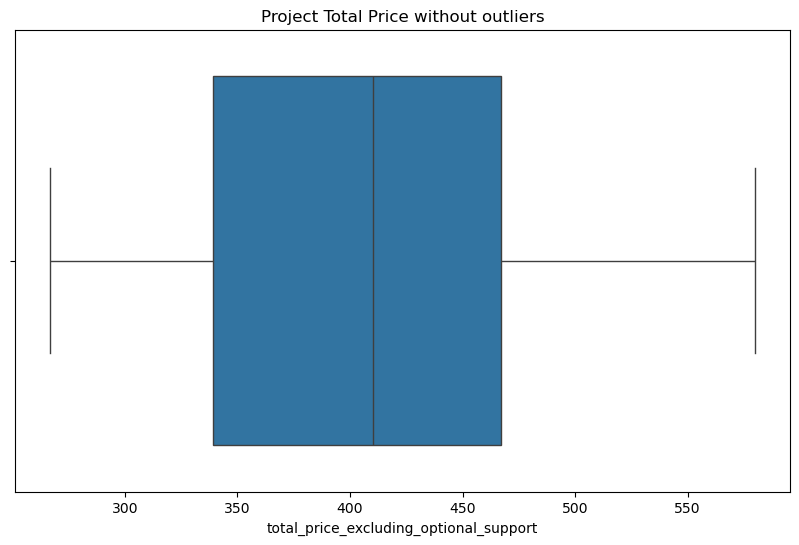

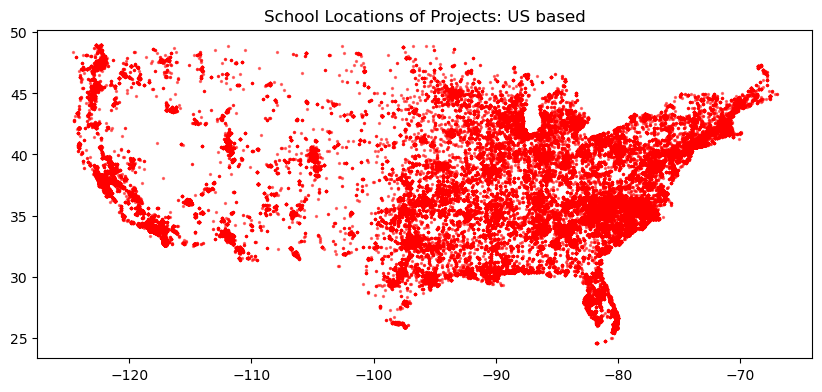

In [5]:
Q1 = data['total_price_excluding_optional_support'].quantile(0.25)
Q3 = data['total_price_excluding_optional_support'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[
    (data['total_price_excluding_optional_support'] >= Q1) &
    (data['total_price_excluding_optional_support'] <= Q3)
]

# Boxplot without outliers (EDA)
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['total_price_excluding_optional_support'])
plt.title('Project Total Price without outliers')
plt.show()

# Map with GeoPandas (basic demo)
gdf = gpd.GeoDataFrame(data.dropna(subset=['school_latitude', 'school_longitude']),
                       geometry=gpd.points_from_xy(data.school_longitude, data.school_latitude))
gdf.plot(marker='o', color='red', markersize=2, figsize=(10, 8), alpha=0.5)
plt.title("School Locations of Projects: US based")
plt.show()

In [6]:
print(data.columns.tolist())

['school_latitude', 'school_longitude', 'total_price_excluding_optional_support', 'students_reached', 'essay_length', 'total_quantity', 'avg_unit_price', 'max_unit_price', 'total_cost', 'avg_total_cost', 'fully_funded', 'school_state_AL', 'school_state_AR', 'school_state_AZ', 'school_state_CA', 'school_state_CO', 'school_state_CT', 'school_state_DC', 'school_state_DE', 'school_state_FL', 'school_state_GA', 'school_state_HI', 'school_state_IA', 'school_state_ID', 'school_state_IL', 'school_state_IN', 'school_state_KS', 'school_state_KY', 'school_state_LA', 'school_state_La', 'school_state_MA', 'school_state_MD', 'school_state_ME', 'school_state_MI', 'school_state_MN', 'school_state_MO', 'school_state_MS', 'school_state_MT', 'school_state_NC', 'school_state_ND', 'school_state_NE', 'school_state_NH', 'school_state_NJ', 'school_state_NM', 'school_state_NV', 'school_state_NY', 'school_state_OH', 'school_state_OK', 'school_state_OR', 'school_state_PA', 'school_state_RI', 'school_state_SC', '

fully_funded
1    0.695406
0    0.304594
Name: proportion, dtype: float64


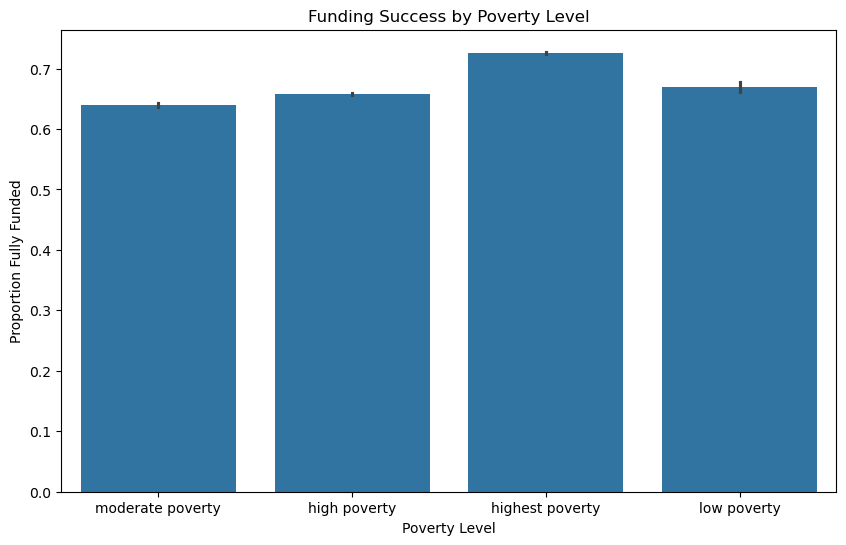

In [7]:
print(demographics['fully_funded'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.barplot(x='poverty_level', y='fully_funded', data=demographics, estimator=np.mean)
plt.title('Funding Success by Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Proportion Fully Funded')
plt.show()

#missing values and box plots/outliers - make sure

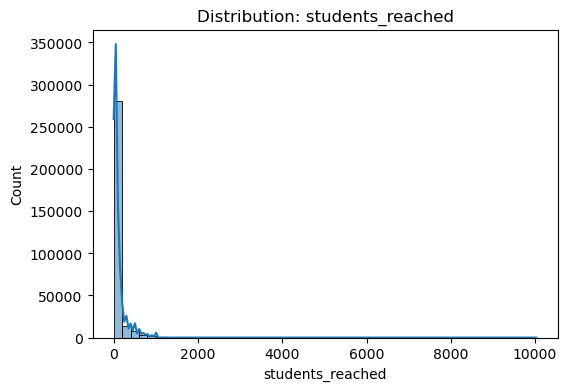

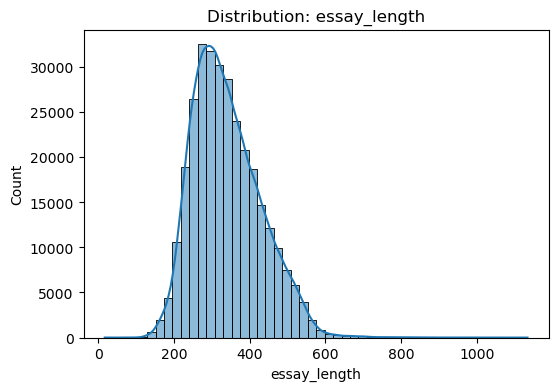

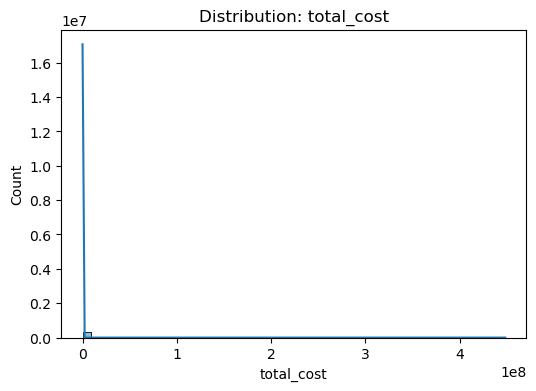

In [24]:
num_features = ['students_reached', 'essay_length', 'total_cost']

for col in num_features:
    if col in data.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(data[col], bins=50, kde=True)
        plt.title(f'Distribution: {col}')
        plt.show()

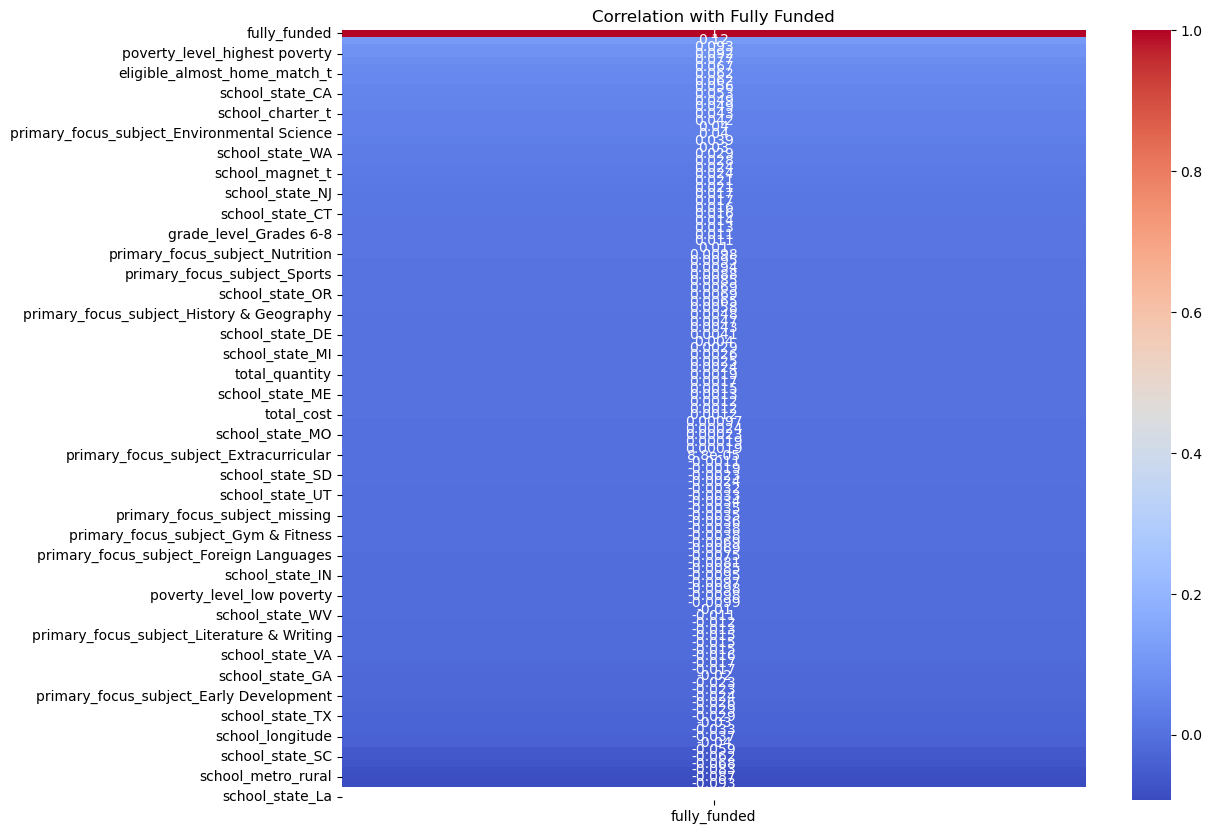

In [25]:
plt.figure(figsize=(12, 10))
corr = data.corr()
sns.heatmap(corr[['fully_funded']].sort_values(by='fully_funded', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation with Fully Funded')
plt.show()

# 2. Model Preparation

In [8]:
X = data.drop(columns=['fully_funded','school_latitude', 'school_longitude'])
y = data['fully_funded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=20
)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

smote = SMOTE(random_state=20)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 'essay_sentiment'

# 3. Model Run

### Without SMOTE

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
# --- Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=20
)

rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_auc_test = roc_auc_score(y_test, y_proba_rf)

print(" Random Forest:")
print("Cross-validated ROC-AUC scores:", rf_cv_scores)
print("Average ROC-AUC:", rf_cv_scores.mean())
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score (Test Set):", rf_auc_test)

# --- XGBoost ---
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=20
)

xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_auc_test = roc_auc_score(y_test, y_proba_xgb)

print("\n XGBoost:")
print("Cross-validated ROC-AUC scores:", xgb_cv_scores)
print("Average ROC-AUC:", xgb_cv_scores.mean())
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score (Test Set):", xgb_auc_test)

results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Test ROC-AUC': [rf_auc_test, xgb_auc_test],
    'CV ROC-AUC (mean)': [rf_cv_scores.mean(), xgb_cv_scores.mean()]
})
print("\n Model Comparison Summary:")
print(results)

 Random Forest:
Cross-validated ROC-AUC scores: [0.67166997 0.67010542 0.67597603 0.6721869  0.67917377]
Average ROC-AUC: 0.6738224176182209

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.43      0.62      0.51     19087
           1       0.79      0.63      0.70     42490

    accuracy                           0.63     61577
   macro avg       0.61      0.63      0.61     61577
weighted avg       0.68      0.63      0.64     61577

ROC-AUC Score (Test Set): 0.6758011540546839

 XGBoost:
Cross-validated ROC-AUC scores: [0.68546979 0.68174259 0.68718733 0.68375569 0.688592  ]
Average ROC-AUC: 0.6853494788205479

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.43      0.66      0.52     19087
           1       0.80      0.61      0.69     42490

    accuracy                           0.62     61577
   macro avg       0.61      0.63      0.61     61577
weighted 

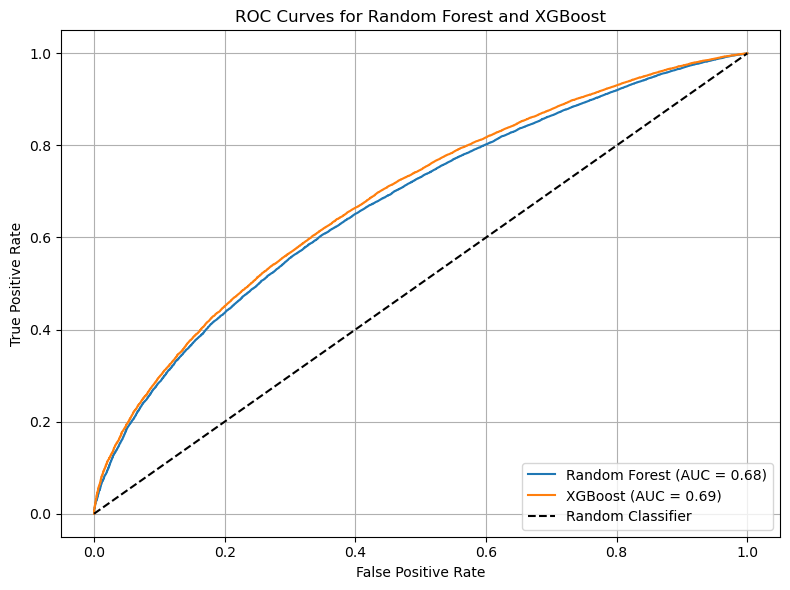

In [10]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(rf_auc_test))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(xgb_auc_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest and XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### After SMOTE

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=20
)
rf.fit(X_train_bal, y_train_bal)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=20
)
xgb.fit(X_train_bal, y_train_bal)

models = {'Random Forest': rf, 'XGBoost': xgb}

In [16]:
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc')
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n{name}")
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Random Forest
ROC-AUC: 0.6586817391369537
Precision: 0.7564851485148515
Recall: 0.7192751235584843
F1: 0.737411026661841
              precision    recall  f1-score   support

           0       0.44      0.48      0.46     19087
           1       0.76      0.72      0.74     42490

    accuracy                           0.65     61577
   macro avg       0.60      0.60      0.60     61577
weighted avg       0.66      0.65      0.65     61577


XGBoost
ROC-AUC: 0.6724312463388863
Precision: 0.7343190504928586
Recall: 0.8590962579430454
F1: 0.791822125813449
              precision    recall  f1-score   support

           0       0.50      0.31      0.38     19087
           1       0.73      0.86      0.79     42490

    accuracy                           0.69     61577
   macro avg       0.61      0.58      0.59     61577
weighted avg       0.66      0.69      0.66     61577



# Permutation Importance

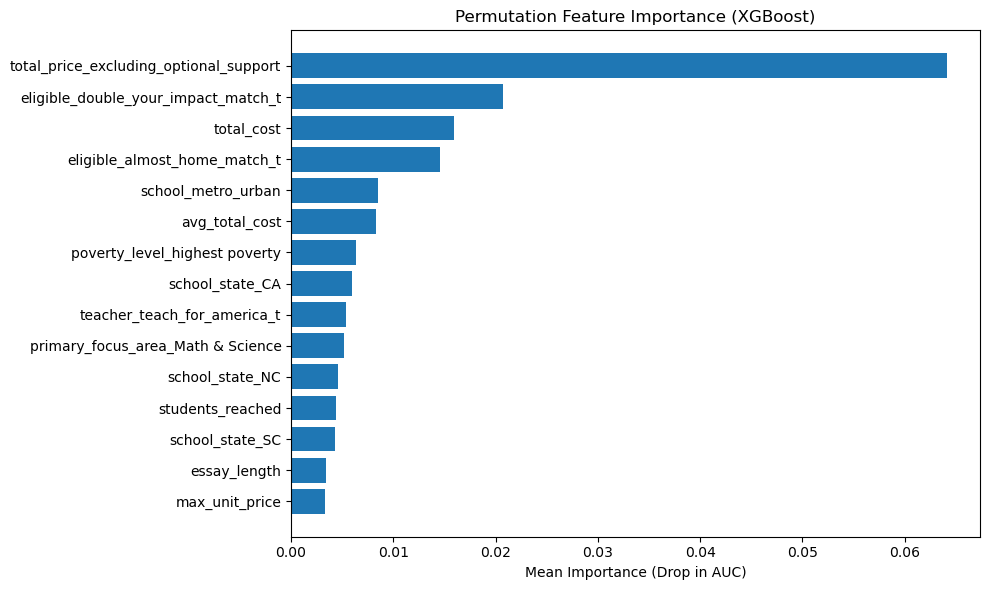

In [17]:
result = permutation_importance(
    xgb_model, X_test_scaled, y_test,
    n_repeats=10,
    scoring='roc_auc',
    random_state=20,
    n_jobs=-1
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance Mean'][:15][::-1])
plt.xlabel('Mean Importance (Drop in AUC)')
plt.title('Permutation Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# compute_fairness

In [18]:
def compute_fairness(data, group_col):
    results = []

    for group in data[group_col].unique():
        sub = data[data[group_col] == group]
        y_true = sub['y_true']
        y_pred = sub['y_pred']

        if len(np.unique(y_true)) < 2:
            continue  # Skip if only one class exists

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
        PPR = (tp + fp) / len(sub)

        results.append({
            group_col: group,
            'TPR': TPR,
            'FPR': FPR,
            'PPR': PPR,
            'Support': len(sub)
        })

    return pd.DataFrame(results)

In [19]:
test_results = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred,
    'y_prob': y_prob,
})

demographics_test = demographics.loc[X_test.index]
test_results['poverty_level'] = demographics_test['poverty_level'].values[:len(test_results)]
test_results['school_metro'] = demographics_test['school_metro'].values[:len(test_results)]

poverty_fairness = compute_fairness(test_results, 'poverty_level')
print("Fairness by Poverty Level:\n", poverty_fairness)

metro_fairness = compute_fairness(test_results, 'school_metro')
print("\nFairness by School Metro Type:\n", metro_fairness)

Fairness by Poverty Level:
       poverty_level       TPR       FPR       PPR  Support
0      high poverty  0.803383  0.617590  0.737488    16125
1   highest poverty  0.902992  0.767331  0.865791    35877
2  moderate poverty  0.753298  0.578896  0.687715     8140
3       low poverty  0.832298  0.754797  0.806969     1435

Fairness by School Metro Type:
   school_metro       TPR       FPR       PPR  Support
0     suburban  0.827174  0.682435  0.778137    13914
1        urban  0.935650  0.849233  0.913146    32526
2        rural  0.617548  0.394528  0.525171     7588
